In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from IPython.display import clear_output, display
from scipy import fft, fftpack
from statsmodels.distributions.empirical_distribution import ECDF
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False

In [2]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib inline

In [3]:
data_load_second_interval = 5
#second_interval = 10
minute_interval = 1
#non_reoccuring_number = 500
min_peak_size = 5000

In [4]:
peaks_by_size = pd.read_csv("../../data/peaks/peaks_by_size_extended.csv")
series_start_time = pd.read_csv("../../data/peaks/peak_start_times.csv")
detected_peaks = pd.read_csv("../../data/peaks/detected_peaks.csv")
undetected_peaks = pd.read_csv("../../data/peaks/undetected_peaks.csv")
series_start_time_improved = pd.read_csv("../../data/peaks/peak_start_times.csv")
peaks_by_size_above_min = peaks_by_size[peaks_by_size['count'] > min_peak_size].copy()

In [5]:
detected_peaks

Unnamed: 0  size_rank                              hash   total_time  \
0             0          0  3fda7f1f0e3fedeceb98ccd934225e2e    23.916667   
1             1          1  bb3e055a01e82ce2de88ca2f1f7dad21     4.666667   
2             2          2  446d6a64560cc8e8e842809d6a634b47    15.500000   
3             3          3  2f51e6166ce33e64688bc03376a73823    16.000000   
4             4          4  455fcfaed2092b4b65d035769548c79e     8.666667   
..          ...        ...                               ...          ...   
828         856        856  46b8d7baeafca477ca3009002a72ee54     8.666667   
829         858        858  8faa38ca67548127107c7e40a8ef90e2    66.500000   
830         860        860  978c63b00ff9d62303775fa4796299c5  1828.416667   
831         861        861  34267722df433f49bf258c965351cc8f    66.250000   
832         863        863  462651d0aa056a92c44bd5dec299857c    25.916667   

     fast_detection         series_start            peak_time  
0              True  2019-06-14 12:00:15  2019-06-14 12:24:10  
1              True  2019-06-30 12:43:00  2019-06-30 12:47:40  
2              True  2019-08-01 11:51:10  2019-08-01 12:06:40  
3              True  2019-07-19 13:03:10  2019-07-19 13:19:10  
4              True  2019-06-18 10:32:00  2019-06-18 10:40:40  
..              ...                  ...                  ...  
828            True  2019-07-02 10:54:50  2019-07-02 11:03:30  
829           False  2019-07-19 06:06:00  2019-07-19 07:12:30  
830           False  2019-06-20 06:49:35  2019-06-21 13:18:00  
831           False  2019-06-25 05:12:15  2019-06-25 06:18:30  
832           False  2019-07-05 13:53:05  2019-07-05 14:19:00  

[833 rows x 7 columns]

In [6]:
series_start_time_improved['peak_time'] = pd.to_datetime(series_start_time_improved['peak_time'])
series_start_time_improved['series_start'] = pd.to_datetime(series_start_time_improved['series_start'])
#series_start_time_improved['total_time'] = pd.to_numeric(series_start_time_improved['total_time'])

In [9]:
data = pd.read_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{data_load_second_interval}s.csv")
data['ndt'] = pd.to_datetime(data['ndt'])
data = data[data['hash'].isin(peaks_by_size['hash'])]
data = data.groupby(['hash','ndt']).sum()
data = pd.DataFrame(data, columns=['count'])

In [7]:
# peak_start group is by the minute, it is the time it took the series to reach max-std, all values above 75% are capped
series_start_time_improved['peak_start_group'] = series_start_time_improved['total_time'].apply(lambda x: x if x < series_start_time_improved['total_time'].quantile(0.95) else series_start_time_improved['total_time'].quantile(0.95))
# Rank group - groups series by their popularity 0-9 most popular, 10-19, 20-29...
series_start_time_improved['rank_group'] = series_start_time_improved['size_rank'].apply(lambda x: int(math.floor(x / 10) * 10))

In [23]:
fig, ax = plt.subplots(1, 1, dpi=150) #, tight_layout=True
fig.set_size_inches(w=5.10686, h=2.75)

bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160, 170, 180, 60000]
series_start_time_improved[series_start_time_improved['total_time'] > 0]['total_time'].value_counts(bins=bins, sort=False).plot(kind='bar', ax=ax)
ax.set_xlabel(f"Peak start from series start (minutes)")
plt.xticks(fontsize=7, rotation=90)
ax.set_ylabel(f"Interval counts")
ax.set_title('Peak start time for series')
fig.savefig('../../plots/text-plots/7-peak_start-histogram.pgf')

In [8]:
series_start_time_improved[series_start_time_improved['total_time'] > 0]['total_time'].describe()

count      833.000000
mean       128.147659
std       1959.605730
min          1.833333
25%         10.666667
50%         18.083333
75%         46.916667
max      55790.333333
Name: total_time, dtype: float64

In [24]:
ecdf_start = ECDF(series_start_time_improved[series_start_time_improved['total_time'] > 0]['total_time'])
#

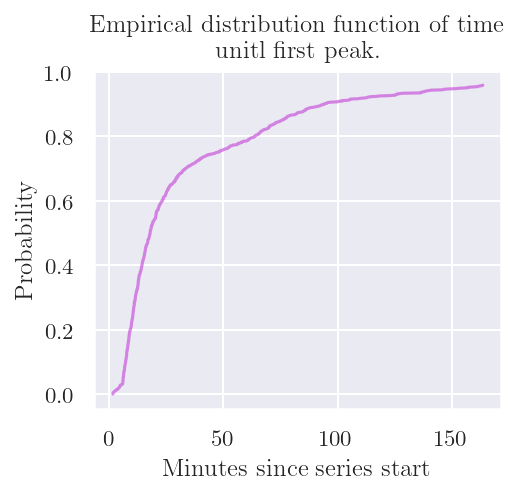

In [32]:
fig, ax = plt.subplots(1, 1, dpi=150)
fig.set_size_inches(w=3.5, h=3)

ax.plot(ecdf_start.x[:800], ecdf_start.y[:800], color=sns.color_palette("hls", 5)[4], alpha=0.7)

ax.set_title('Empirical distribution function of time\nunitl first peak.')
ax.set_xlabel(f"Minutes since series start")
ax.set_ylabel(f"Probability")
fig.savefig('../../plots/text-plots/7-peak_start-emp-dist-fnc.pgf')

Text(0.5, 1.0, 'Peak start time for slow-detected peak series')

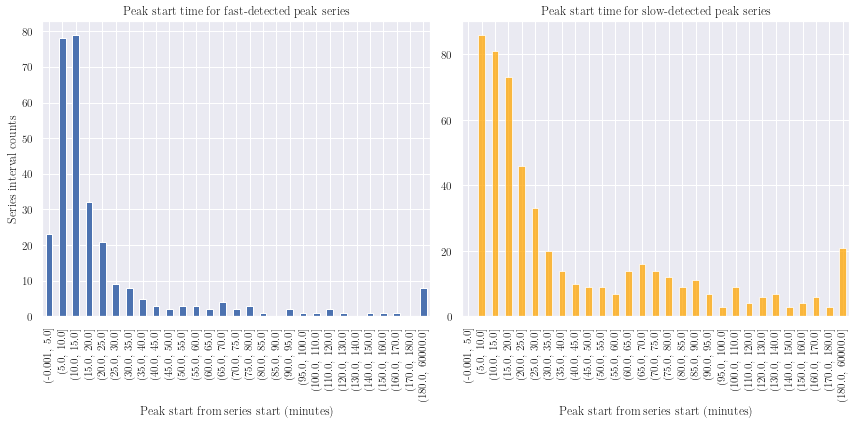

In [64]:
fig, ax = plt.subplots(1, 2, tight_layout=True)
fig.set_size_inches(12, 6)
series_start_time_improved[(series_start_time_improved['total_time'] > 0) & (series_start_time_improved['fast_detection'] == True)]['total_time']\
                        .value_counts(bins=bins, sort=False).plot(kind='bar', ax=ax[0])
series_start_time_improved[(series_start_time_improved['total_time'] > 0) & (series_start_time_improved['fast_detection'] == False)]['total_time']\
                        .value_counts(bins=bins, sort=False).plot(kind='bar', color='orange', ax=ax[1], alpha=0.75)
ax[0].set_xlabel(f"Peak start from series start (minutes)")
ax[0].set_ylabel(f"Series interval counts")
ax[0].set_title('Peak start time for fast-detected peak series')
ax[1].set_xlabel(f"Peak start from series start (minutes)")
ax[1].set_ylabel("")
ax[1].set_title('Peak start time for slow-detected peak series')

In [66]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_size_inches(12, 6)
sns.scatterplot(x=series_start_time_improved['rank_group'],y=series_start_time_improved['peak_start_group'], alpha=0.5)
ax.set_xlabel(f"Top N (group) series by size")
ax.set_ylabel(f"Peak start from series start (minutes)")
ax.set_title('Peak start time for series')
fig.savefig('../../plots/text-plots/7-peak_start-minutes-by-size.pgf')

In [10]:
peak_slope = []
peak_size = []
for index, row in series_start_time_improved.iterrows():
    print(f"{index+1}/{len(series_start_time_improved)}",end='\r')
    clear_output(wait=True)

    series = row['hash']
    peak_time = row['peak_time']
    series_data = data.loc[series].resample('60S').sum().fillna(0)[:peak_time]
    
    peak_size.append(series_data.iloc[-1].values[0])
    
    if(len(series_data) == 0):
        peak_slope.append(0)
        continue
    
    series_mod = linear_model.LinearRegression()
    
    x = np.arange(0, len(series_data)).reshape(-1, 1)
    y = series_data['count'].values
    
    series_mod.fit(x, y)
    peak_slope.append(series_mod.coef_[0])
series_start_time_improved['slope'] = pd.Series(peak_slope) 
series_start_time_improved['peak_size'] = pd.Series(peak_size)

In [11]:
size_slope = pd.merge(peaks_by_size, series_start_time_improved, on='hash', how='right')[['count','slope','peak_size']]
size_slope = size_slope[size_slope['slope'] > -3] # Causes issues with latex

In [12]:
fig, ax = plt.subplots(1, 2, tight_layout=True, dpi=150)
fig.set_size_inches(w=5.10686, h=3)
sns.regplot(x=size_slope['count'], y=size_slope['slope'], line_kws={'color':'orange'}, ax=ax[0])
ax[0].set_xlabel('Series requests')
ax[0].set_ylabel('Best fit line slope')
ax[0].set_title('Relationship between series size\nand first-peak best-fit line slope', pad=20)


#fig, ax = plt.subplots(1, 1, dpi=150)
#fig.set_size_inches(w=5.10686, h=3.2)
sns.regplot(x=size_slope['peak_size'], y=size_slope['slope'], line_kws={'color':'orange'}, ax=ax[1])
ax[1].set_xlabel('Peak size')
ax[1].set_ylabel('')
ax[1].set_title('Relationship between peak size\nand first-peak best-fit line slope', pad=20)

fig.savefig('../../plots/text-plots/7-size-peak-slope-relationship.pgf')


In [11]:

#fig.savefig('../../plots/text-plots/7-local-size-peak-slope-relationship.pgf')

Text(0.5, 1.0, 'Relationship between peak size\nand first-peak best-fit line slope')

In [12]:
size_slope.corr()

count     slope  peak_size
count      1.000000  0.452576   0.570940
slope      0.452576  1.000000   0.786746
peak_size  0.570940  0.786746   1.000000

## Dropoff ##

In [13]:
series_dropoff_25 = []
series_dropoff_50 = []
series_dropoff_75 = []

for row in series_start_time_improved.iterrows():
    series_id = row[1]['hash']
    series_peak_start = row[1]['peak_time']
    series_data = data.loc[series_id]
    series_mean_window = series_data.loc[series_peak_start - timedelta(minutes=5):series_peak_start + timedelta(minutes=5)]
    # Mean window size
    window_size = int(10*60/data_load_second_interval) # 10 minute index skip
    peak_window_mean = series_mean_window.mean()[0] # peak_start:window_size mean
    # Post-peak window moving average
    post_peak_moving_average = series_data[series_peak_start - timedelta(minutes=5):].rolling(window_size).mean()
    
    dropoff_25 = post_peak_moving_average[post_peak_moving_average <= (peak_window_mean * 0.75)].dropna()
    dropoff_50 = post_peak_moving_average[post_peak_moving_average <= (peak_window_mean * 0.50)].dropna()
    dropoff_75 = post_peak_moving_average[post_peak_moving_average <= (peak_window_mean * 0.25)].dropna()
    
    if(len(dropoff_25) > 0):
        dropoff_25_time = dropoff_25.index[0]
    else:
        dropoff_25_time = series_peak_start#series_data.index[-1]
    
    if(len(dropoff_50) > 0):
        dropoff_50_time = dropoff_50.index[0]
    else:
        dropoff_50_time = series_peak_start#series_data.index[-1]
        
    if(len(dropoff_75) > 0):
        dropoff_75_time = dropoff_75.index[0]
    else:
        dropoff_75_time = series_peak_start#series_data.index[-1]
    
    series_dropoff_25.append(dropoff_25_time)
    series_dropoff_50.append(dropoff_50_time)
    series_dropoff_75.append(dropoff_75_time)
    
series_start_time_improved['dropoff_25'] = series_dropoff_25
series_start_time_improved['dropoff_50'] = series_dropoff_50
series_start_time_improved['dropoff_75'] = series_dropoff_75

In [14]:
series_start_time_improved['dropoff_25_minutes'] = (series_start_time_improved['dropoff_25'] - series_start_time_improved['peak_time']).dt.total_seconds()/60
series_start_time_improved['dropoff_50_minutes'] = (series_start_time_improved['dropoff_50'] - series_start_time_improved['peak_time']).dt.total_seconds()/60
series_start_time_improved['dropoff_75_minutes'] = (series_start_time_improved['dropoff_75'] - series_start_time_improved['peak_time']).dt.total_seconds()/60


bin_intervals=[0.1,10,20,30,40,50,60,90,120,150,180,210,240,270,300,500,700,900,1100]
hist_25 = series_start_time_improved['dropoff_25_minutes'].value_counts(bins=bin_intervals, sort=False)
hist_50 = series_start_time_improved['dropoff_50_minutes'].value_counts(bins=bin_intervals, sort=False)
hist_75 = series_start_time_improved['dropoff_75_minutes'].value_counts(bins=bin_intervals, sort=False)

#combined_hist = pd.DataFrame(hist_50.index, columns=['interval'])
#combined_hist['dropoff_25'] = hist_25.values
#combined_hist['dropoff_50'] = hist_50.values
#combined_hist['dropoff_75'] = hist_75.values

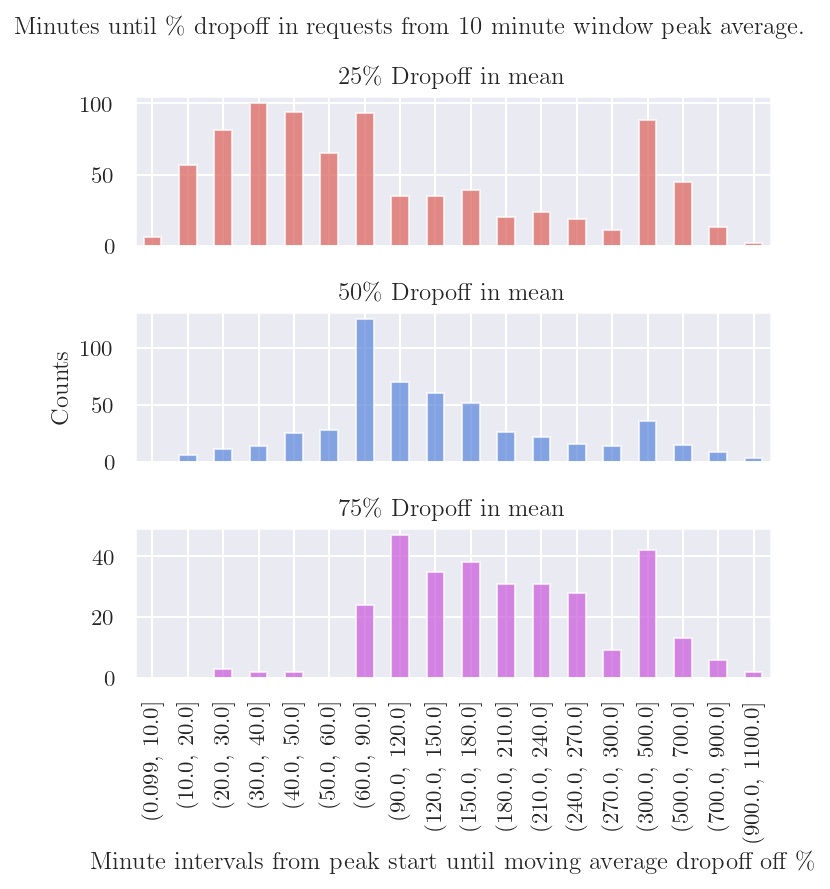

In [16]:
fig, ax = plt.subplots(3, 1, dpi=150, tight_layout=True)
fig.set_size_inches(w=5.10686, h=6)



hist_25.plot(kind='bar', ax=ax[0], color=sns.color_palette("hls", 3)[0], alpha=0.7)
hist_50.plot(kind='bar', ax=ax[1], color=sns.color_palette("hls", 5)[3], alpha=0.7)
hist_75.plot(kind='bar', ax=ax[2], color=sns.color_palette("hls", 5)[4], alpha=0.7)
fig.suptitle('Minutes until \% dropoff in requests from 10 minute window peak average.')#, fontsize=16)
ax[2].set_xlabel(f"Minute intervals from peak start until moving average dropoff off \%")
ax[1].set_ylabel(f"Counts")
ax[0].set_title('25\% Dropoff in mean')
ax[1].set_title('50\% Dropoff in mean')
ax[2].set_title('75\% Dropoff in mean')

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

fig.savefig('../../plots/text-plots/7-dropoff-counts.pgf')

In [16]:
series_start_time_improved[series_start_time_improved['total_time'] > 0][['dropoff_25_minutes', 'dropoff_50_minutes', 'dropoff_75_minutes']].describe()

dropoff_25_minutes  dropoff_50_minutes  dropoff_75_minutes
count          833.000000          833.000000          833.000000
mean           159.051220          303.523709          183.475990
std            218.377603         1141.406469          892.347332
min              0.000000            0.000000            0.000000
25%             36.333333            0.000000            0.000000
50%             62.500000           75.500000            0.000000
75%            199.916667          167.583333          158.916667
max           2937.833333        14291.500000        17190.166667

In [60]:
ecdf_25 = ECDF(series_start_time_improved[series_start_time_improved['total_time'] > 0]['dropoff_25_minutes'])
ecdf_50 = ECDF(series_start_time_improved[series_start_time_improved['total_time'] > 0]['dropoff_50_minutes'])
ecdf_75 = ECDF(series_start_time_improved[series_start_time_improved['total_time'] > 0]['dropoff_75_minutes'])

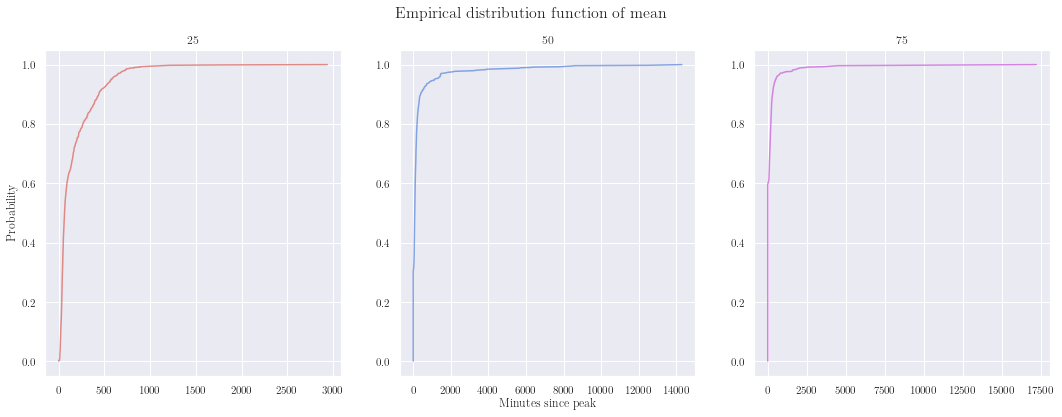

In [67]:
fig, ax = plt.subplots(1, 3, tight_layout=False)
fig.set_size_inches(18, 6)
# TODO 2500
ax[0].plot(ecdf_25.x[:2500], ecdf_25.y[:2500], color=sns.color_palette("hls", 3)[0], alpha=0.7)
ax[1].plot(ecdf_50.x[:2500], ecdf_50.y[:2500], color=sns.color_palette("hls", 5)[3], alpha=0.7)
ax[2].plot(ecdf_75.x[:2500], ecdf_75.y[:2500], color=sns.color_palette("hls", 5)[4], alpha=0.7)

fig.suptitle('Empirical distribution function of mean % dropoff in minutes.', fontsize=16)
ax[1].set_xlabel(f"Minutes since peak")
ax[0].set_ylabel(f"Probability")
ax[0].set_title('25% Dropoff in mean')
ax[1].set_title('50% Dropoff in mean')
ax[2].set_title('75% Dropoff in mean')

fig.savefig('../../plots/text-plots/7-dropoff-emp.pgf')

In [18]:
size_75 = []
size_50 = []
size_25 = []
for row in series_start_time_improved.iterrows():
    series_id = row[1]['hash']
    series_data = data.loc[series_id]
    series_peak_start = row[1]['peak_time']
    series_peak_dropoff_25 = row[1]['dropoff_25']
    series_peak_dropoff_50 = row[1]['dropoff_50']
    series_peak_dropoff_75= row[1]['dropoff_75']
    
    peak_data_75 = series_data.loc[series_peak_start:series_peak_dropoff_75]
    peak_data_50 = peak_data_75.loc[:series_peak_dropoff_50]
    peak_data_25 = peak_data_75.loc[:series_peak_dropoff_25]
    
    size_75.append(peak_data_75.sum()[0]) 
    size_50.append(peak_data_50.sum()[0])
    size_25.append(peak_data_25.sum()[0])

In [19]:
series_start_time_improved['peak_size_until_75d'] = size_75
series_start_time_improved['peak_size_until_50d'] = size_50
series_start_time_improved['peak_size_until_25d'] = size_25
series_start_time_improved['total_size'] = peaks_by_size_above_min['count']
series_start_time_improved['ratio_75d'] = series_start_time_improved['peak_size_until_75d']/series_start_time_improved['total_size'] * 100
series_start_time_improved['ratio_50d'] = series_start_time_improved['peak_size_until_50d']/series_start_time_improved['total_size'] * 100
series_start_time_improved['ratio_25d'] = series_start_time_improved['peak_size_until_25d']/series_start_time_improved['total_size'] * 100

In [21]:
series_start_time_improved[series_start_time_improved['total_time'] > 0][['ratio_25d','ratio_50d','ratio_75d']].describe()

ratio_25d   ratio_50d   ratio_75d
count  833.000000  833.000000  833.000000
mean    10.919210   18.937094   27.736492
std     17.115470   26.057259   35.443391
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      0.029802    0.029802    0.029802
75%     19.126585   39.804820   67.287449
max     94.928262   95.451007   96.296296

In [62]:
fig, ax = plt.subplots(1, 3, tight_layout=True)
fig.set_size_inches(18, 6)

percentage_bins = [0,10,20,30,40,50,60,70,80,90,100]
series_start_time_improved[series_start_time_improved['total_time'] > 0]['ratio_25d'].value_counts(bins=percentage_bins, sort=False).plot(kind='bar', ax=ax[0], color=sns.color_palette("hls", 3)[0], alpha=0.7)
series_start_time_improved[series_start_time_improved['total_time'] > 0]['ratio_50d'].value_counts(bins=percentage_bins, sort=False).plot(kind='bar', ax=ax[1], color=sns.color_palette("hls", 5)[3], alpha=0.7)
series_start_time_improved[series_start_time_improved['total_time'] > 0]['ratio_75d'].value_counts(bins=percentage_bins, sort=False).plot(kind='bar', ax=ax[2], color=sns.color_palette("hls", 5)[4], alpha=0.7)

<AxesSubplot:>

<AxesSubplot:>

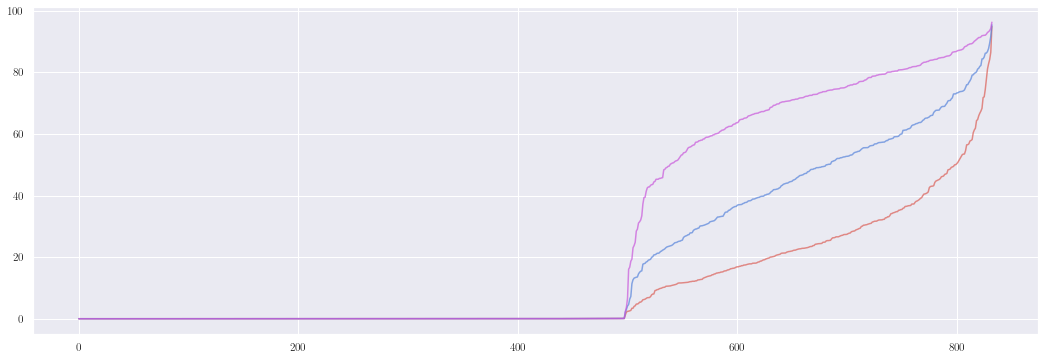

In [63]:
fig, ax = plt.subplots(1, 1, tight_layout=False)
fig.set_size_inches(18, 6)

percentage_bins = [0,10,20,30,40,50,60,70,80,90,100]
series_start_time_improved[series_start_time_improved['total_time'] > 0]['ratio_25d'].sort_values().plot(use_index=False,ax=ax, color=sns.color_palette("hls", 3)[0], alpha=0.7)
series_start_time_improved[series_start_time_improved['total_time'] > 0]['ratio_50d'].sort_values().plot(use_index=False,ax=ax, color=sns.color_palette("hls", 5)[3], alpha=0.7)
series_start_time_improved[series_start_time_improved['total_time'] > 0]['ratio_75d'].sort_values().plot(use_index=False,ax=ax, color=sns.color_palette("hls", 5)[4], alpha=0.7)

In [20]:
fig, ax = plt.subplots(3, 1, dpi=150, tight_layout=True)
fig.set_size_inches(w=5.10686, h=6)

sns.scatterplot(data=series_start_time_improved[series_start_time_improved['total_time'] > 0], x="total_size", y="ratio_25d", ax=ax[0], color=sns.color_palette("hls", 3)[0], alpha=0.7)
sns.scatterplot(data=series_start_time_improved[series_start_time_improved['total_time'] > 0], x="total_size", y="ratio_50d", ax=ax[1], color=sns.color_palette("hls", 5)[3], alpha=0.7)
sns.scatterplot(data=series_start_time_improved[series_start_time_improved['total_time'] > 0], x="total_size", y="ratio_75d", ax=ax[2], color=sns.color_palette("hls", 5)[4], alpha=0.7)

fig.suptitle('Series size to request share from peak to dropoff.', fontsize=16)
ax[0].set_ylabel("")
ax[1].set_ylabel(f"Percentage share of requests sum since peak until dropoff")
ax[2].set_ylabel("")

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel(f"Series size as a sum of requests")


ax[0].set_title('25% Dropoff in mean')
ax[1].set_title('50% Dropoff in mean')
ax[2].set_title('75% Dropoff in mean')


fig.savefig('../../plots/text-plots/7-dropoff-scatterplot-size.pgf')